# Shopee - Price Match Guarantee ==> Deployment And API Creation

### Importing Libraries

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#Importing Necessary Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import warnings 
import zipfile
import tqdm
from PIL import Image
from io import BytesIO
import cv2
from tensorflow.keras.applications import EfficientNetB2
import cuml
from cuml.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import regex as re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# import these modules
from nltk.stem import WordNetLemmatizer
import regex as re
lemmatizer = WordNetLemmatizer()
from numpy import zeros
from numpy import concatenate
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Creating the complete DataPipeline For predictions

In [17]:

def get_similar_images(img_path, title, phash, num_matches):

  #Step:1 ====> Reading the image and resizing
  sample_image = zeros((1, 224, 224, 3),dtype='float32')
  image = cv2.imread(img_path)
  sample_image[0, ] = cv2.resize(image, (224, 224))

  #Step2: ====> Getting the Image Embeddings by loading model efficientNetB2
  model_effB2 = load_model('/content/drive/MyDrive/AppliedAI/DocumentClassification/efficientB2.h5')
  embeds_image = model_effB2.predict(sample_image, use_multiprocessing=True, workers=4, verbose = 3)


  #Step3: ====> Preprocessing the Title and getting the embeddings of title
  Input_Text = title.lower()
  Input_Text = re.sub(r'[\n\t\r\\-]+', ' ', Input_Text)
  Input_Text = re.sub(r"won't", "will not", Input_Text)
  Input_Text = re.sub(r"can\'t", "can not", Input_Text)
  Input_Text = re.sub(r"n\'t", " not", Input_Text)
  Input_Text = re.sub(r"\'re", " are", Input_Text)
  Input_Text = re.sub(r"\'s", " is", Input_Text)
  Input_Text = re.sub(r"\'d", " would", Input_Text)
  Input_Text = re.sub(r"\'ll", " will", Input_Text)
  Input_Text = re.sub(r"\'t", " not", Input_Text)
  Input_Text = re.sub(r"\'ve", " have", Input_Text)
  Input_Text = re.sub(r"\'m", " am", Input_Text)
  Input_Text = re.sub(r"[^0-9a-zA-Z_]+", ' ', Input_Text) 
  new_Text = ''
  all_tokens = nltk.word_tokenize(Input_Text)
  for word in all_tokens:
    if word not in stop_words:
      lemma = lemmatizer.lemmatize(word)
      new_Text += ' ' + lemma
  new_Text = new_Text.lstrip()

  #Step4: getting title embedings and loading the tfidf model
  tfidf_title_vectorizer =  joblib.load('/content/drive/MyDrive/AppliedAI/DocumentClassification/tfidf_vectorizer.pickle') 
  tfidf_title_features = joblib.load('/content/drive/MyDrive/AppliedAI/DocumentClassification/all_title_features.pickle')
  embeds_texts = tfidf_title_vectorizer.transform([title])
  # print("Preprocess Completed and got the embeddings to title")


  #Step5: Loading the efficientNetB2 Knn model
  knn_model = joblib.load('/content/drive/MyDrive/AppliedAI/DocumentClassification/knn_effenet_model.pkl')


  #Step6: getting Image similar Ids
  img_distances, img_indices = knn_model.kneighbors(embeds_image)
  index = np.where(img_distances < 5)[0]
  post_ids = img_indices[index][0]
  pred_images = train_data.iloc[post_ids]["posting_id"].values

  #Step7: getting title similar Ids
  pair_distances = pairwise_distances(tfidf_title_features, embeds_texts.reshape(1, -1))
  pair_distances = pair_distances.flatten()
  indices_labells = np.argsort(pair_distances)[0:num_matches]
  pred_titles = train_data.iloc[indices_labells]['posting_id'].values

  #step8: getting similar Image_phash
  pred_image_phash = train_data[train_data['image_phash'] == phash]['posting_id'].values


  #getting the unique in all the three predictions
  unique_preds = np.unique(np.concatenate([pred_titles, pred_image_phash, pred_images]))

  # print("returing the all unique predicted")
  return unique_preds  


### Sanity Checking with Sample Test cases

**Product1**

pridicting Top 2 Similar Images


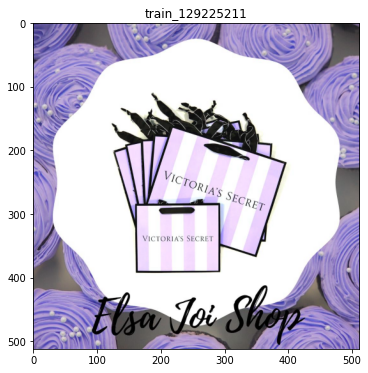

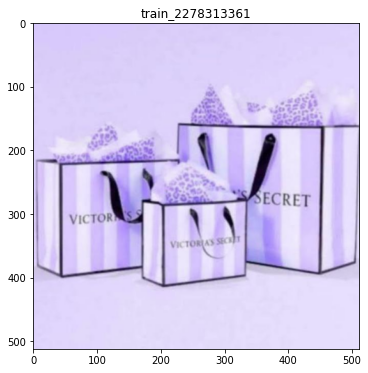

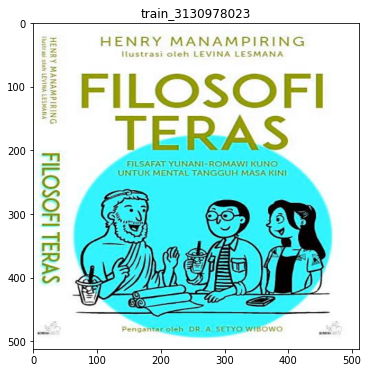

In [20]:
img_path = '/content/train_images/' + '0000a68812bc7e98c42888dfb1c07da0.jpg'
title = "Paper Bag Victoria Secret"
phash = "94974f937d4c2433"
num_matches = 2
unique_preds = get_similar_images(img_path, title, phash, num_matches)
tup_post_images = []
for i in range(0, len(unique_preds)):
  p_id = train_data[train_data['posting_id'] == unique_preds[i]]['posting_id'].values.tolist()
  img_id = train_data[train_data['posting_id'] == unique_preds[i]]['image'].values.tolist()
  tup_post_images.append((p_id, img_id))

print("pridicting Top 2 Similar Images")
for i in range(0, len(tup_post_images)):
  image_path = '/content/train_images/' + tup_post_images[i][1][0]
  posting_ids = tup_post_images[i][0][0]
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512))

  plt.figure(figsize=(10,6))
  plt.subplot(111)
  plt.title(posting_ids)
  plt.imshow(image)

In [74]:
print("The Correct Predictions are: ", train_data.iloc[0]['matches'])

The Correct Predictions are:  ['train_129225211' 'train_2278313361']


**Product2**

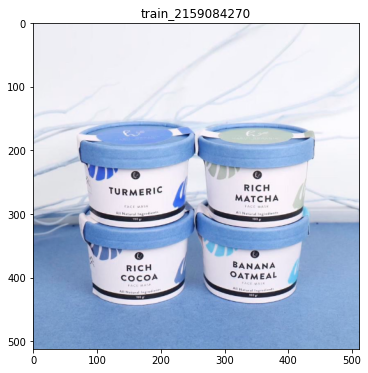

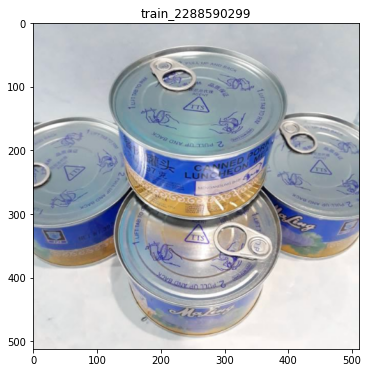

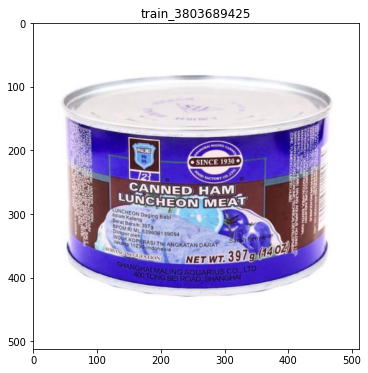

In [22]:
img_path = '/content/train_images/' + '000a190fdd715a2a36faed16e2c65df7.jpg'
title = "Maling TTS Canned Pork Luncheon Meat 397 gr"
phash = "b94cb00ed3e50f78"
num_matches = 2
unique_preds = get_similar_images(img_path, title, phash, num_matches)
tup_post_images = []
for i in range(0, len(unique_preds)):
  p_id = train_data[train_data['posting_id'] == unique_preds[i]]['posting_id'].values.tolist()
  img_id = train_data[train_data['posting_id'] == unique_preds[i]]['image'].values.tolist()
  tup_post_images.append((p_id, img_id))

for i in range(0, len(tup_post_images)):
  image_path = '/content/train_images/' + tup_post_images[i][1][0]
  posting_ids = tup_post_images[i][0][0]
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512))

  plt.figure(figsize=(10,6))
  plt.subplot(111)
  plt.title(posting_ids)
  plt.imshow(image)

In [ ]:
print("The Correct Predictions are: ", train_data.iloc[2]['matches'])

The Correct Predictions are:  ['train_2288590299' 'train_3803689425']


**Product3**

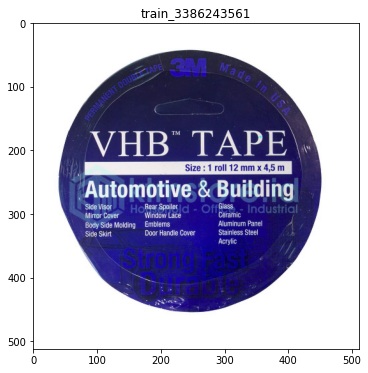

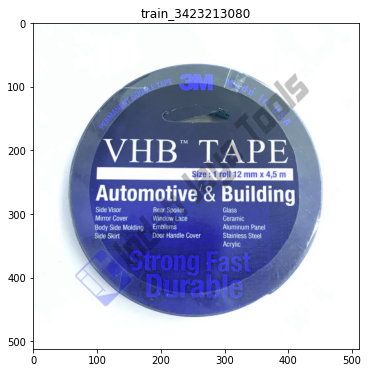

In [23]:
img_path = '/content/train_images/' + '00039780dfc94d01db8676fe789ecd05.jpg'
title = "Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE"
phash = "af3f9460c2838f0f"
num_matches = 2
unique_preds = get_similar_images(img_path, title, phash, num_matches)
tup_post_images = []

for i in range(0, len(unique_preds)):
  p_id = train_data[train_data['posting_id'] == unique_preds[i]]['posting_id'].values.tolist()
  img_id = train_data[train_data['posting_id'] == unique_preds[i]]['image'].values.tolist()
  tup_post_images.append((p_id, img_id))

for i in range(0, len(tup_post_images)):
  image_path = '/content/train_images/' + tup_post_images[i][1][0]
  posting_ids = tup_post_images[i][0][0]
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512))

  plt.figure(figsize=(10,6))
  plt.subplot(111)
  plt.title(posting_ids)
  plt.imshow(image)

In [65]:
print("The Correct Predictions are: ", train_data.iloc[1]['matches'])

The Correct Predictions are:  ['train_3386243561' 'train_3423213080']


**Product4**

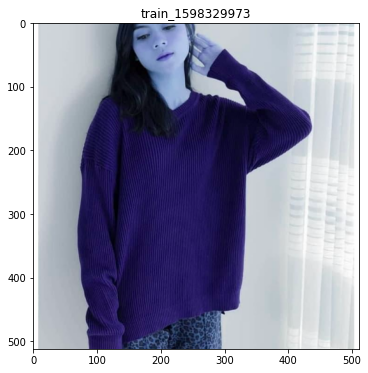

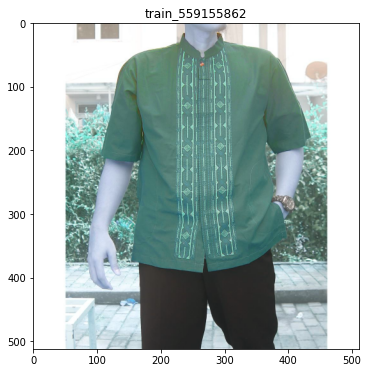

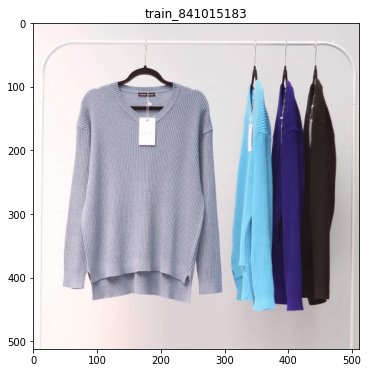

In [25]:
img_path = '/content/train_images/' + '001d7f5d9a2fac714f4d5f37b3baffb4.jpg'
title = "Atasan Rajut Wanita LISDIA SWEATER"
phash = "bec8d09693634b4b"
num_matches = 2
unique_preds = get_similar_images(img_path, title, phash, num_matches)
tup_post_images = []

for i in range(0, len(unique_preds)):
  p_id = train_data[train_data['posting_id'] == unique_preds[i]]['posting_id'].values.tolist()
  img_id = train_data[train_data['posting_id'] == unique_preds[i]]['image'].values.tolist()
  tup_post_images.append((p_id, img_id))

for i in range(0, len(tup_post_images)):
  image_path = '/content/train_images/' + tup_post_images[i][1][0]
  posting_ids = tup_post_images[i][0][0]
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512))

  plt.figure(figsize=(10,6))
  plt.subplot(111)
  plt.title(posting_ids)
  plt.imshow(image)

**Product5**

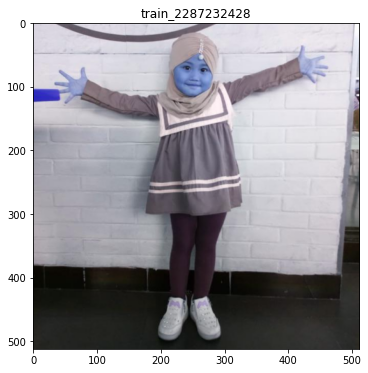

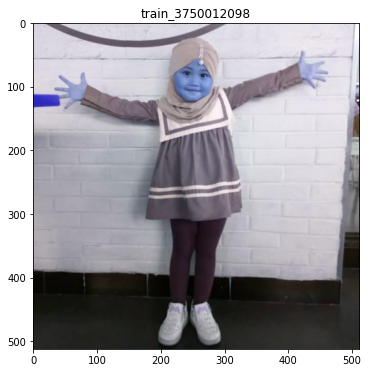

In [31]:
img_path = '/content/train_images/' + '1859e6be8283cb97f2f471b735bab22b.jpg'
title = "Savanna top"
phash = "b7b348f3b800b71c"
num_matches = 2
unique_preds = get_similar_images(img_path, title, phash, num_matches)
tup_post_images = []

for i in range(0, len(unique_preds)):
  p_id = train_data[train_data['posting_id'] == unique_preds[i]]['posting_id'].values.tolist()
  img_id = train_data[train_data['posting_id'] == unique_preds[i]]['image'].values.tolist()
  tup_post_images.append((p_id, img_id))

for i in range(0, len(tup_post_images)):
  image_path = '/content/train_images/' + tup_post_images[i][1][0]
  posting_ids = tup_post_images[i][0][0]
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512))

  plt.figure(figsize=(10,6))
  plt.subplot(111)
  plt.title(posting_ids)
  plt.imshow(image)

In [29]:
print("The Correct Predictions are: ", train_data.iloc[3000]['matches'])

The Correct Predictions are:  ['train_2287232428' 'train_3750012098']


**From Above It is Clear that Our predictions are almost Correct.**